## This is a demostration of *split strike* option trading strategy in  `python` 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy.optimize as so
import pandas.io.data as web
from pandas.io.data import Options
import pandas as pd
import matplotlib.cm as cm

###Note: Writing a `C` or `Fortran` extension for Black-Scholes model is worthy the effort

In [2]:
#-------------------------------------------------------------------------------
# Name:        Black-Scholes Calculator w/ Dividend
# Purpose:     Integrate robust pricing model to replace limited Excel functionality
#
# Author:      Jamie A. Edwards
#
# Created:     18/06/2012
# Copyright:   (c) Jamie 2012
# Licence:     <your licence>
#-------------------------------------------------------------------------------

from scipy import stats
import math
import numpy as np

def black_scholes (cp, stk_p, op_sk, exp_t, iv, rf, div):
        """ Price an option using the Black-Scholes model.
        cp   : +1/-1 for call/put
        stk_p: initial stock price
        op_sk: option strike price
        exp_t: expiration time in years
        iv   : implied volatility
        rf   : risk-free interest rate
        div  : dividend
        """
        cp, s, k, t, v, rf, div = cp, stk_p, op_sk, exp_t, iv, rf, div
        d1 = (np.log(s*1./k)+(rf-div+0.5*np.power(v,2))*t)/(v*np.sqrt(t))
        d2 = d1 - v*np.sqrt(t)

        optprice = (cp*s*np.exp(-div*t)*stats.norm.cdf(cp*d1)) - (cp*k*np.exp(-rf*t)*stats.norm.cdf(cp*d2))
        return optprice

#code from Paper by Sanjiv R. Das and Brian Granger
#web address: http://algo.scu.edu/~sanjivdas/cython.pdf

### Solver example: solver for implied volatility 

In [3]:
def BK_v(v, real_price, cp, s, k, t, rf, div):
    '''Target function for solving implied volatility'''
    return  (black_scholes(cp, s, k, t, v, rf, div)-real_price)**2

In [4]:
# 192.00	
# SPY160916C00192000
# 15.97
# 15.03
# 15.16
# 0.00
# 0.00%
# 1	
# 56
# 19.13%
# stock trading at 192.33 on Sept 4, 2015
# 1 year treasure interest rate Sept 03: 0.37
so.fmin(BK_v, 0.35, args=(15.03, 1, 192.47, 192, 1, 0.001, 0))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 14
         Function evaluations: 28


array([ 0.19202148])

###Visualize the expiry-price relationship

In [5]:
def BK_time(t, cp, s, k, v, rf, div):
    '''B-S model with expiry time as 1st argv'''
    return black_scholes(cp, s, k, t, v, rf, div)

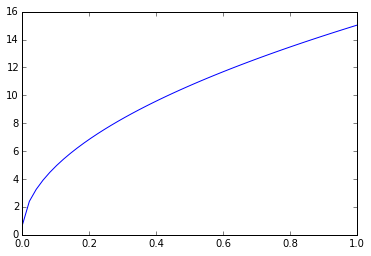

In [6]:
plt.plot(np.linspace(0.001,1),
         BK_time(np.linspace(0.001,1), 1, 192.47, 192, 0.192, 0.001, 0))
#Stock price 192.47
#Volatility 19.2%
#Call option, strike price 192
#interset rate 0.001, dividend 0.

### Getting the option prices using `pandas`

In [7]:
#Free option price data source:

#http://finance.yahoo.com/q/op?s=SPY&date=1473984000
#https://www.google.com/finance/option_chain?q=SPY&expd=16&expm=09&expy=2016&output=json
#http://www.google.com/finance/option_chain?cid=4755&expd=17&expm=1&expy=2015&output=json

In [9]:
spy = Options('SPY', 'yahoo')

In [10]:
df_spy = spy.get_all_data()

In [11]:
df_spy.index.get_level_values(1).unique()

DatetimeIndex(['2015-12-19', '2017-12-15', '2016-12-16', '2016-01-15',
               '2016-06-17', '2017-01-20', '2017-03-17', '2017-06-16',
               '2016-09-16', '2016-03-18', '2017-09-15', '2015-11-20',
               '2015-11-06', '2015-10-23', '2015-10-30', '2016-09-30',
               '2015-12-31', '2016-03-31', '2016-06-30', '2015-11-13',
               '2015-11-27'],
              dtype='datetime64[ns]', name=u'Expiry', freq=None, tz=None)

### Getting the call options and put options with 2016-09-16 expiry

In [12]:
df_spy_call = df_spy.ix[(df_spy.index.get_level_values(1) == pd.to_datetime('2016-09-16'))&\
                        (df_spy.index.get_level_values(2) == 'call'),:]

In [13]:
df_spy_put  = df_spy.ix[(df_spy.index.get_level_values(1) == pd.to_datetime('2016-09-16'))&\
                        (df_spy.index.get_level_values(2) == 'put'),:]

In [14]:
#Selecting cheap options, i.e., those are out-of-money
df_cnd = pd.concat((df_spy_call.query('Bid<11 and Bid>1'),
                    df_spy_put.query('Bid<11 and Bid>1')))

In [15]:
df_cnd.sort('Bid').tail(6)

,,,,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time
Strike,Expiry,Type,Symbol,,,,,,,,,,,,,
184,2016-09-16,put,SPY160916P00184000,9.79,9.55,9.67,0.00,0.00%,30,106,22.39%,SPY,False,SPY,200.16,2015-10-15 11:43:00
185,2016-09-16,put,SPY160916P00185000,9.75,9.84,9.96,-0.33,-3.27%,700,1629,22.24%,SPY,False,SPY,200.16,2015-10-15 11:43:00
205,2016-09-16,call,SPY160916C00205000,10.02,9.99,10.15,0.00,0.00%,10,6594,16.06%,SPY,False,SPY,200.16,2015-10-15 11:43:00
186,2016-09-16,put,SPY160916P00186000,10.40,10.14,10.27,0.00,0.00%,16,1066,22.11%,SPY,False,SPY,200.16,2015-10-15 11:43:00
187,2016-09-16,put,SPY160916P00187000,10.70,10.44,10.58,0.00,0.00%,38,131,21.96%,SPY,False,SPY,200.16,2015-10-15 11:43:00
188,2016-09-16,put,SPY160916P00188000,11.03,10.76,10.89,0.00,0.00%,33,2112,21.81%,SPY,False,SPY,200.16,2015-10-15 11:43:00


In [17]:
#let's simplified it, assuming we are:
# 11 months to expriry
# Interset rate 0.001
# Diviend 0.0
# for 2016-09-16 205 call:
black_scholes(1, 200.16, 205, 11./12, 0.1606, 0.001, 0)
#real price 9.99

10.220685011897942

In [18]:
# for 2016-09-16 185 put:
black_scholes(-1, 200.16, 185, 11./12, 0.2224, 0.001, 0)
#real price 9.84

9.7808999703461552

### Visualize the return curve of *split strike* strategy

#### Grey line indicates the returns of long stock position.
#### Colors indicates return-price curves of different time-to-expiry

In [19]:
def BK_realprice(s, cp, k, t, v, rf, div):
    '''BK model with Stock Price as 1st argv'''
    return black_scholes(cp, s, k, t, v, rf, div)

In [20]:
def split_strike(call_op, put_op, call_iv, put_iv, crt_sp,
                 price_range=None,
                 time_range=np.linspace(0,1,13),
                 rfi = 0.001,
                 divd = 0.0,
                 put_cp = 0.0,
                 call_cp = 0.0,
                 equal_weight = False,
                 ax=None):
    '''Plot the Price-Return relationship of Split Strike Strategy'''
    if ax==None:
        plt.figure(figsize=(7, 5))
        ax=plt.gca()
    if equal_weight & ((put_cp*call_cp)!=0):
        call_weight = put_cp*1./call_cp
        init_credit = 0.0
    else:
        call_weight = 1.0
        init_credit = put_cp-call_cp
    #Warning: put_op must < call_op
    if price_range==None:
        price_range = np.linspace(put_op*0.8, call_op*1.2, 50)
    #long calls, short puts
    for t, c in zip(time_range[::-1],
                    cm.jet(np.linspace(0,1,len(time_range)))[::-1]):
        ax.plot(price_range,
                call_weight*BK_realprice(price_range, 1, call_op, t, call_iv, rfi, divd)\
                -BK_realprice(price_range, -1, put_op, t, put_iv, rfi, divd)\
                +init_credit,
                c=c, label='%0.1f'%(t*12), alpha=0.6)
    ax.plot(price_range, price_range-crt_sp, c='k', alpha=0.25, lw=3, label='Long')
    ax.set_xlim((np.min(price_range)-np.ptp(price_range)*0.05,
                 np.max(price_range)+np.ptp(price_range)*0.35))
    ax.legend(title='Month to Exp.', loc='right', 
              ncol=1, frameon=False)
    ax.set_title('Split Strike: C(%.1f) P(%.1f). Stock: %.2f. Wt:%.2f'%(call_op, 
                                                                        put_op,
                                                                        crt_sp,
                                                                        call_weight))
    ax.grid('on')

In [21]:
def SS(call_op, put_op, expiry, df, *args, **kwargs):
    '''Warp of Split Strike Plotting method, takes a DataFrame'''
    total_time = ((pd.to_datetime(expiry)-
                   pd.to_datetime('Now')).total_seconds())/31556926.
    #warn price not found
    idx_call = (df.index.get_level_values(0)==call_op)&(df.index.get_level_values(2)=='call')
    idx_put  = (df.index.get_level_values(0)==put_op)&(df.index.get_level_values(2)=='put')
    #warn expiry not found
    idx_expy = (df.index.get_level_values(1)==pd.to_datetime(expiry))
    call_cp, call_iv, crt_sp = df.ix[idx_call&idx_expy,
                                     ['Bid','IV','Underlying_Price']].values.ravel()
    call_iv  = float(call_iv.replace('%',''))/100
    put_cp, put_iv = df.ix[idx_put&idx_expy, ['Bid','IV']].values.ravel()
    put_iv  = float(put_iv.replace('%',''))/100
    split_strike(call_op, put_op, call_iv, put_iv, crt_sp,
                 time_range=np.linspace(0.00001,total_time,13),
                 put_cp=put_cp, call_cp=call_cp,
                 *args, **kwargs)
    return (call_cp, call_iv), (put_cp, put_iv), put_cp-call_cp
    #split_strike(205, 165, 0.1754, 0.2756, 192.28)

((9.99, 0.1606), (5.31, 0.2535), -4.680000000000001)

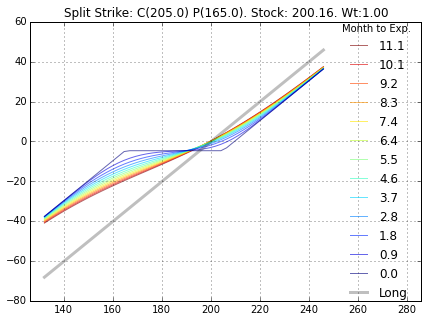

In [22]:
#Arguments: 
#Call options strike price, (long)
#Put option strike price, (short)
#Expiry
#Option price DataFrame

SS(205, 165, '2016-09-16', df_spy)

((14.56, 0.1617), (13.35, 0.2397), -1.2100000000000009)

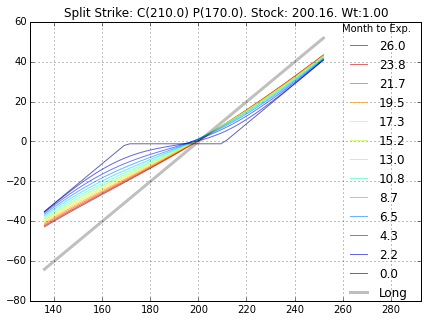

In [23]:
SS(210, 170, '2017-12-15', df_spy)

### Visualize price-expriry curve.
#### Color represents moneyness. Out-of-money options in blue.
#### Options of equal moneyness are in the same color

In [24]:
def OOM_plot(df, high_limit, low_limit, two_axes=None, cmap=cm.jet):
    '''Out of money Time-OptionPrice plot'''

    Epry = sorted(df.index.get_level_values(1).unique().values)
    Strk = np.array([item for item in df.index.get_level_values(0).unique()
                     if (item<=high_limit)&(item>=low_limit)])
    Max_moneyness = (np.abs(Strk - df.Underlying_Price[0])).max()
    if two_axes == None:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)
    else:
        ax1, ax2 = two_axes
    for S in Strk:
        _df1 = df.ix[((df.index.get_level_values(1).isin(Epry)) & 
                      (df.index.get_level_values(2) == 'call')  &
                      (df.index.get_level_values(0) == S)), 
                     ['Bid']].reset_index()
        _df2 = df.ix[((df.index.get_level_values(1).isin(Epry)) & 
                      (df.index.get_level_values(2) == 'put')  &
                      (df.index.get_level_values(0) == S)), 
                     ['Bid']].reset_index()
        if (len(_df1)>0) & (S>df.Underlying_Price[0]):
            ax1.plot(_df1.Expiry, _df1.Bid, 
                      color=cmap([0,
                                  np.abs(S - df.Underlying_Price[0])/Max_moneyness,
                                  1][1]))
        if (len(_df2)>0) & (S<df.Underlying_Price[0]):
            ax2.plot(_df2.Expiry, _df2.Bid,
                      color=cmap([0,
                                  np.abs(S - df.Underlying_Price[0])/Max_moneyness,
                                  1][1]))
    ax1.set_title('Call Options')
    ax2.set_title('Put Options')
    plt.setp(ax1.get_xticklabels(), rotation=90)
    plt.setp(ax2.get_xticklabels(), rotation=90)
#    return _df1

(-0.5, 0.5, 49.5, -0.5)

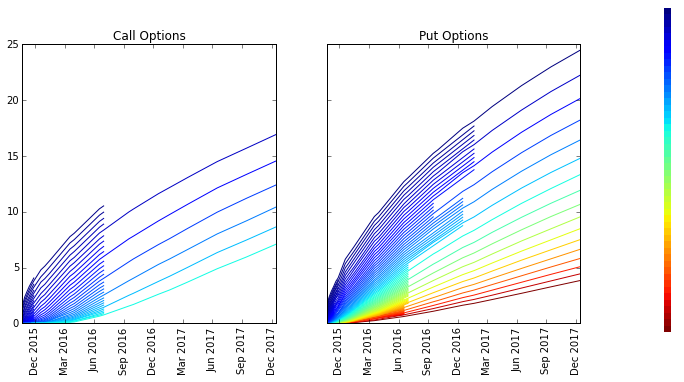

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)
OOM_plot(df_spy, 230, 120, two_axes=(ax1, ax2))

#moneyness can go on the cax (colorbar axis)
cax = f.add_axes([0.98, 0.1, 0.08, 0.9])
cax.imshow(cm.jet(np.linspace(0,1,50)).reshape(-1,1,4), interpolation='nearest')
plt.axis('off')

#Notice from above:
#for out-of-money options, put options are more expensive than the call options of the same moneyness.